# Model Training and Optimization Section

## **1st Model** - **Baseline ARIMAX**

Using the parameters (1,1,0) from above, we create a simple model. Here we will fit the model using the prices of 'Coal.SA' and p,d,q parameter values.
Later, we will forecast the values of 'Coal.SA' and evaluate the loss.

### **Model Fitting**

In [ ]:
from pandas import datetime
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

model = SARIMAX(df.iloc[0:288]["Coal.SA"])
model_fit = model.fit(disp=0)
results=model.fit()

### **Forecasting**

In [67]:
# FROM and TO prediction dates
start_index = datetime(2016, 1, 1)
end_index = datetime(2020, 7, 1)

<Figure size 864x720 with 0 Axes>

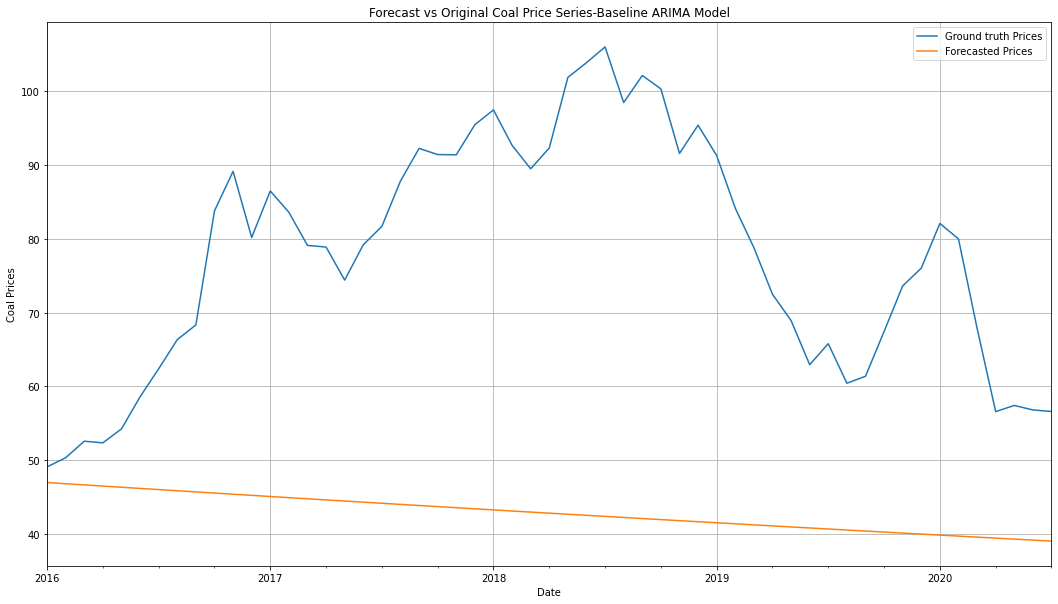

In [68]:
mpl.rcParams['axes.grid'] = True ## Set true for getting grid lines
plt.figure(figsize=(12,10));
df['forecasted_arima_baseline']=results.predict(start=start_index, end=end_index)
df.iloc[-55:][['Coal.SA','forecasted_arima_baseline']].plot();
plt.title("Forecast vs Original Coal Price Series-Baseline ARIMA Model");
plt.ylabel("Coal Prices")
plt.legend(labels=("Ground truth Prices","Forecasted Prices"))

Above plot indicates that the model fits quite badly and the forecast results are not good at all.

Now we are interested in evaluating our model using the RMSE and R^2. In the best case scenario, RMSE should be close to 0 and R^2 should be nearly 1.

### **Model Evaluation**

In [69]:
from sklearn.metrics import mean_squared_error, r2_score

actual=df["Coal.SA"][-55:]
forecast=df["forecasted_arima_baseline"][-55:]
actual = actual.values
forecast = forecast.values
print("RMSE =",mean_squared_error(actual, forecast, squared = False))
print("R^2 score =", round(r2_score(actual, forecast), 2))

RMSE = 38.53688006725719
R^2 score = -4.89


The above results depict that ARIMA model with these parameters cannot perform well on this prediction. Thus, we further explore other approaches to improve the model.

The dataset is a multivariate time series with more than one time-dependent variable. Our target attribute, "Coal.SA" depends on its past values but also is dependent on other variables. This dependency should also be taken into account when making predicting. 

In the first model, we did not make use of other attributes to fit our model. We only used the past values of "Coal.SA" to predict its future values. 

One approach that worths to try is including the exogenous variables in the very same model. These are the variables whose value is determined outside the model and is imposed on the model. Since the other variables in our model have high correlation with "Coal.SA", they might influence the value of target variable. So we will include those attributes to train our model. 


## **2nd Model** - **ARIMAX with Exogenous Features**

#### **Adding exogenous features**

In [70]:
for_exog_array = final_features
for_exog_array = for_exog_array.drop(['Coal.SA'], axis=1)

# Storing the exogenous features
# Apart from our target feature, all othe features with high correlation with target feature 
# can be considered as the exogenous features. 
exog = for_exog_array.to_numpy()

In [71]:
# Here we store exogenous features acc. to train and forecast sets separation.
exog_train = exog[0:288][:]
exog_forecast = exog[-55:][:]
print(exog_train.shape)
print(exog_forecast.shape)

(288, 9)
(55, 9)


### **Model Fitting**

In [72]:
# Including exogenous features to train our model
# Here again, we only select the training data excluding test time interval 1992-2016
model2 = SARIMAX(df.iloc[0:288]['Coal.SA'], order=(1,1,0), seasonal_order=(0,0,0,13), exog=exog_train)
model_fit2 = model2.fit(disp=0)
results2 = model2.fit()

### **Model Evaluation**

In [73]:
df['forecast_arima_exo'] = results2.predict(start=start_index, end=end_index, exog=exog_forecast)
forecast2 = df["forecast_arima_exo"][-55:]

print("RMSE =",mean_squared_error(actual, forecast2, squared = False))
print("R^2 score =", round(r2_score(actual, forecast2), 2))

RMSE = 11.7463408738393
R^2 score = 0.45


We observe that by adding the exogenous variables to our model, the RMSE score reduced 15 points and R^2 improved by 3.5 points. Thus, we can conclude that involvement of exogenous variables boost model performance.

However, obtained results are far away from satisfactory. We can still experiment some options to improve the accuaracy of our model. We would want to explore some other combinations of the parameters that might improve the model.

<Figure size 864x720 with 0 Axes>

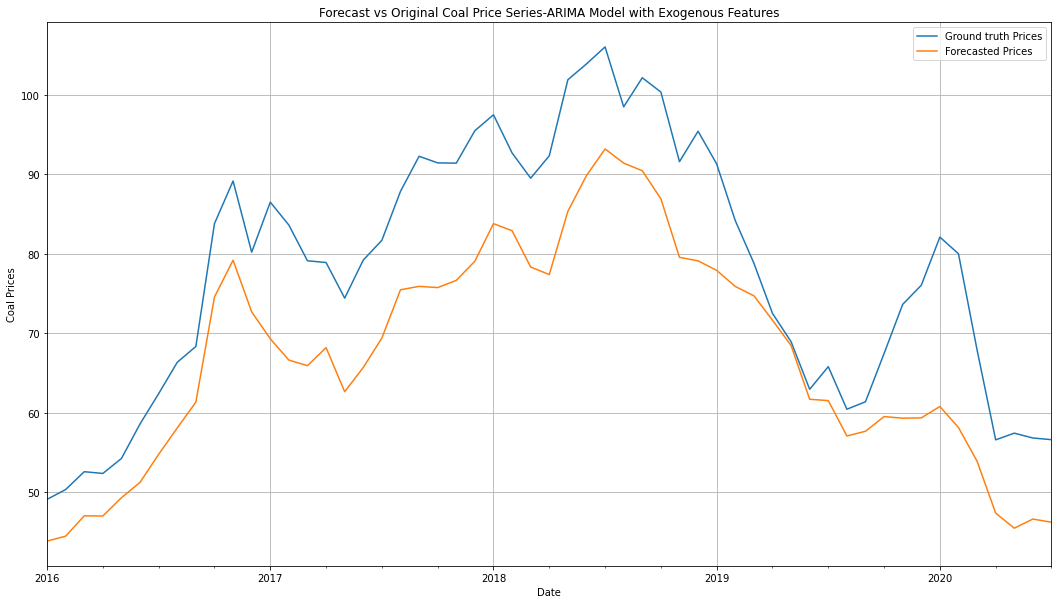

In [74]:
mpl.rcParams['axes.grid'] = True ## Set true for getting grid lines
plt.figure(figsize=(12,10));
df.iloc[-55:][['Coal.SA','forecast_arima_exo']].plot();
plt.title("Forecast vs Original Coal Price Series-ARIMA Model with Exogenous Features");
plt.ylabel("Coal Prices")
plt.legend(labels=("Ground truth Prices","Forecasted Prices"))

## **SARIMAX Model- 6 Parameters**

We keep the seasonality as 0. For chosing the best set of remaining 6 parameters, we plan to try all the combinations of the 6 parameters and use each combination individually to train our SARIMAX model. Now for each SARIMAX model, we can look at the BIC/AIC scores and select the combination of parameters which gives us the least BIC/AIC score.

AIC and BIC are methods to penalize models for having more regressor variables. A penalty function is used in these methods, which is a function of the number of parameters in the model.


1.   When applying AIC, the penalty function is z(p) = 2 p.
2.   When applying BIC, the penalty function is z(p) = p ln(n), which is based on interpreting the penalty as deriving from prior information (hence the name Bayesian Information Criterion).

When n is large, the two models will produce quite different results. Then the BIC applies a much larger penalty for complex models, and hence will lead to simpler models than AIC.

Hence, we prefer low BIC scores over low AIC scores to determine the best model because AIC always has a chance of choosing too big a model, regardless of n. On the other hand, BIC has very little chance of choosing too big a model if n is sufficient.

We will test the models for different values of (p, d and q) and (seasonal_p,seasonal_d and seasonal_q) from (0, 1 and 2) and we keep the seasonal order to be 0 as from the EDA we have observed that there is no seasonality in our data. 
 

In [75]:
import itertools
p = d = q = range(0,3)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 0) for x in list(itertools.product(p,d,q))]
print("examples of parameter combinations or Seasonal ARIMA...")
print("SARIMAX: {} * {}".format(pdq[1], seasonal_pdq[1]))
print("SARIMAX: {} * {}".format(pdq[1], seasonal_pdq[2]))
print("SARIMAX: {} * {}".format(pdq[2], seasonal_pdq[3]))
print("SARIMAX: {} * {}".format(pdq[2], seasonal_pdq[4]))
print("SARIMAX: {} * {}".format(pdq[3], seasonal_pdq[5]))

examples of parameter combinations or Seasonal ARIMA...
SARIMAX: (0, 0, 1) * (0, 0, 1, 0)
SARIMAX: (0, 0, 1) * (0, 0, 2, 0)
SARIMAX: (0, 0, 2) * (0, 1, 0, 0)
SARIMAX: (0, 0, 2) * (0, 1, 1, 0)
SARIMAX: (0, 1, 0) * (0, 1, 2, 0)


We will use all the combination of parameters individually to fit our model and then calculate the BIC scores for all the models. We then display the results in the ascending order of their BIC values.

**Grid Search for best model parameters** (allow some time for execution)

In [76]:
import operator
metric_bic_dict = dict()

for pm in pdq:
  for pm_seasonal in seasonal_pdq:
    try:
      # Here again only training set is included 
      model_test2 = SARIMAX(df.iloc[0:288][:]['Coal.SA'], order=pm, seasonal_order=pm_seasonal, exog=exog_train)
      model_bic = model_test2.fit()
      metric_bic_dict.update({(pm, pm_seasonal):model_bic.bic})
    except:
      continue

sorted_bic = sorted(metric_bic_dict.items(), key=operator.itemgetter(1))
sorted_bic[:10]      

[(((0, 0, 0), (1, 0, 0, 0)), 1455.5753265998117),
 (((1, 0, 0), (0, 0, 0, 0)), 1455.5753265998117),
 (((0, 0, 0), (2, 0, 0, 0)), 1455.9212324918328),
 (((2, 0, 0), (0, 0, 0, 0)), 1455.9212324918328),
 (((0, 0, 0), (1, 0, 1, 0)), 1457.0826169518105),
 (((1, 0, 1), (0, 0, 0, 0)), 1457.0826169518105),
 (((1, 0, 0), (0, 0, 1, 0)), 1457.1372521328183),
 (((0, 0, 1), (1, 0, 0, 0)), 1457.2554810972981),
 (((2, 0, 0), (2, 0, 1, 0)), 1457.9948396494456),
 (((2, 0, 1), (2, 0, 0, 0)), 1459.133867889284)]

Hence, We choose the parameters with lowest BIC scores

## **Final SARIMAX Model**

**Model Fitting**

In [77]:
# Training interval along with training exogenous features are fed into ARIMA model.
final_model = SARIMAX(df[0:288][:]['Coal.SA'], order=(0,0,2), seasonal_order=(0,0,0,0), exog=exog_train)
final_model_fit = final_model.fit(disp=0)
print(final_model_fit.summary())

final_results = final_model.fit()

                           Statespace Model Results                           
Dep. Variable:                Coal.SA   No. Observations:                  288
Model:               SARIMAX(0, 0, 2)   Log Likelihood                -702.726
Date:                Tue, 20 Jul 2021   AIC                           1429.452
Time:                        14:36:14   BIC                           1473.407
Sample:                    01-01-1992   HQIC                          1447.066
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7409      0.025     29.369      0.000       0.691       0.790
x2             0.1984      0.109      1.825      0.068      -0.015       0.411
x3            -0.0394      0.027     -1.447      0.1

### **Model Evaluation**

In [78]:
df['forecast_final_arima'] = final_results.predict(start=start_index, end=end_index, exog=exog_forecast)
forecast_f = df["forecast_final_arima"][-55:]

print("RMSE =",mean_squared_error(actual, forecast_f, squared = False))
print("R^2 score =", round(r2_score(actual, forecast_f), 2))

RMSE = 8.49574232079074
R^2 score = 0.71


### **Forecasting**

<Figure size 864x720 with 0 Axes>

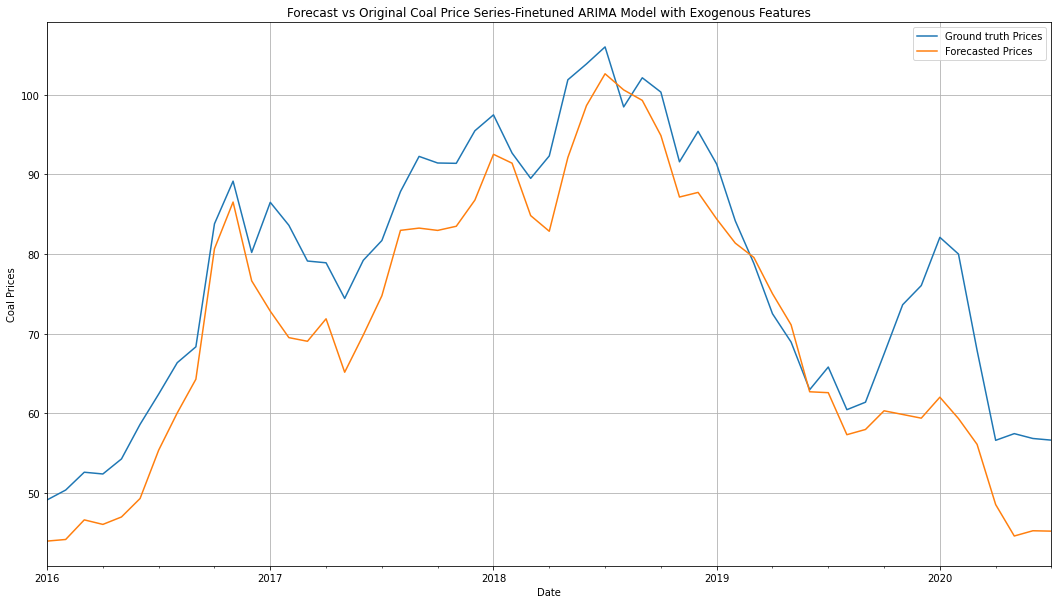

In [79]:
mpl.rcParams['axes.grid'] = True ## Set true for getting grid lines
plt.figure(figsize=(12,10));
df.iloc[-55:][['Coal.SA','forecast_final_arima']].plot();
plt.title("Forecast vs Original Coal Price Series-Finetuned ARIMA Model with Exogenous Features");
plt.ylabel("Coal Prices")
plt.legend(labels=("Ground truth Prices","Forecasted Prices"))

Final Model did a pretty fine job in forecasting the prices with an impressive error rates. 

### Visualizations

<Figure size 864x720 with 0 Axes>

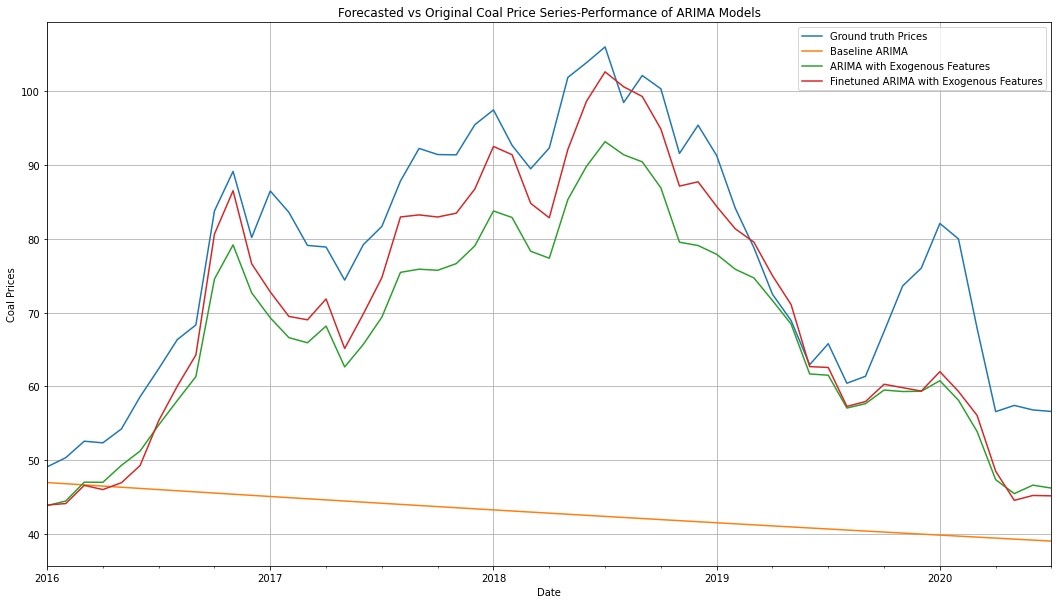

In [81]:
mpl.rcParams['axes.grid'] = True ## Set true for getting grid lines
plt.figure(figsize=(12,10));
df.iloc[-55:][['Coal.SA',"forecasted_arima_baseline", "forecast_arima_exo", 'forecast_final_arima']].plot();
plt.title("Forecasted vs Original Coal Price Series-Performance of ARIMA Models");
plt.ylabel("Coal Prices")
plt.legend(labels=("Ground truth Prices","Baseline ARIMA","ARIMA with Exogenous Features", "Finetuned ARIMA with Exogenous Features")) # Finetuned ARIMA Model with Exogenous Features

# Deep Learning LSTM Model

In [ ]:
# importing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, optimizers
from tensorflow.keras import activations

import talos
from plot_keras_history import plot_history
import matplotlib as mpl

# mpl.rcParams['figure.figsize'] = (12,10)
mpl.rcParams['axes.grid'] = True

In [8]:
# rearranging dataframe columns to have target column at the first column for easy preprocessing
df_lstm = df[['Coal.SA','Coal.Australia', 'Fuel.Index', 'Coal.Producer.Index',
       'IronOre', 'CrudeOil.Index', 'Metal.Index', 'NonFuel.Index',
       'Commodity.Index', 'CCI']]

In [9]:
# checking first 5 rows of dataframe
df_lstm.head()

,Coal.SA,Coal.Australia,Fuel.Index,Coal.Producer.Index,IronOre,CrudeOil.Index,Metal.Index,NonFuel.Index,Commodity.Index,CCI
Date,,,,,,,,,,
1992-01-01,31.0,39.5,23.71,93.6,33.1,40.23,35.59,48.40,50.72,99.36520
1992-02-01,31.0,39.5,23.83,93.8,33.1,41.09,37.12,48.71,50.72,99.46713
1992-03-01,31.0,39.5,23.79,93.6,33.1,41.17,37.41,48.74,50.75,99.62660
1992-04-01,31.0,39.5,25.24,94.1,33.1,44.09,38.00,48.45,51.17,99.72688
1992-05-01,31.0,39.5,26.33,94.7,33.1,45.57,37.99,48.57,52.64,99.75301


Changing the timeseries data into supervised learning data (X,y) by shifting the dataframe to have target variable at time t with all the features until time t-1

In [10]:
#converting series to supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [11]:
# storing row values as array
values = df_lstm.values
df_lstm.dtypes

Coal.SA                float64
Coal.Australia         float64
Fuel.Index             float64
Coal.Producer.Index    float64
IronOre                float64
CrudeOil.Index         float64
Metal.Index            float64
NonFuel.Index          float64
Commodity.Index        float64
CCI                    float64
dtype: object

In [12]:
# Scaling full data using the MinMaxScaler, since all the column values are float
# variables that are measured at different scales do not contribute equally to the model fitting 
# and might end up creating a bias. Thus, to deal with this potential problem, feature-wise normalization 
# such as MinMax Scaling is usually used prior to model fitting
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(values)

# changing data to supervised data as described above
reframed_data = series_to_supervised(data_scaled, 1,1)

In [13]:
# checking head of supervised data
reframed_data.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t)
1,0.066553,0.10935,0.049397,0.075458,0.038851,0.067105,0.066605,0.096039,0.050221,0.458246,0.066553,0.10935,0.050159,0.076923,0.038851,0.070680,0.082355,0.099537,0.050221,0.479446
2,0.066553,0.10935,0.050159,0.076923,0.038851,0.070680,0.082355,0.099537,0.050221,0.479446,0.066553,0.10935,0.049905,0.075458,0.038851,0.071013,0.085341,0.099876,0.050409,0.512613
3,0.066553,0.10935,0.049905,0.075458,0.038851,0.071013,0.085341,0.099876,0.050409,0.512613,0.066553,0.10935,0.059111,0.079121,0.038851,0.083153,0.091414,0.096603,0.053029,0.533470
4,0.066553,0.10935,0.059111,0.079121,0.038851,0.083153,0.091414,0.096603,0.053029,0.533470,0.066553,0.10935,0.066032,0.083516,0.038851,0.089307,0.091312,0.097957,0.062200,0.538904
5,0.066553,0.10935,0.066032,0.083516,0.038851,0.089307,0.091312,0.097957,0.062200,0.538904,0.052901,0.10935,0.074921,0.081319,0.038851,0.099077,0.092238,0.099876,0.063510,0.525446


In [14]:
reframed_data.shape

(338, 20)

In [15]:
#only keep data till time t; t+1, t2, ...all till the end can be dropped, since we only need to predict the target variable at time t
reframed_data.drop(['var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)',
       'var7(t)', 'var8(t)', 'var9(t)', 'var10(t)'], axis=1, inplace=True)

In [16]:
# storing dataframe as array 
values = reframed_data.values

In [17]:
# training_split=287
train = values[:288, :]
test = values[-55:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features] for inputs to LSTM models
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(288, 1, 10) (288,) (55, 1, 10) (55,)


In [18]:
# Helper functions
def make_predictions(model):
  # prediction on the test data
  yhat = model.predict(test_X)
  # reversing the scaling for original and predicted values so that we can compare values normally as coal prices
  test_X_reshape = test_X.reshape((test_X.shape[0], test_X.shape[2]))

  # invert scaling for forecasted values
  inv_yhat = np.concatenate((yhat, test_X_reshape[:, 1:]), axis=1)
  inv_yhat = scaler.inverse_transform(inv_yhat)
  inv_yhat = inv_yhat[:,0]

  # invert scaling for actual values
  test_y_reshape = test_y.reshape((len(test_y), 1))
  inv_y = np.concatenate((test_y_reshape, test_X_reshape[:, 1:]), axis=1)
  inv_y = scaler.inverse_transform(inv_y)
  inv_y = inv_y[:,0]

  return inv_yhat, inv_y

def plot_performance(history, model_name):

  plt.subplots(figsize=(18, 6))

  plt.subplot(1, 3, 1)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(model_name+" "+'Model Loss-MAE', fontsize = 12)
  plt.ylabel('Mean Absolute Loss (MAE)', fontsize = 10)
  plt.xlabel('Epoch', fontsize = 10)
  plt.legend(["Train:{:.3f}".format(history.history["loss"][-1]), "Validation:{:.3f}".format(history.history["val_loss"][-1])], fontsize = 10)

  plt.subplot(1, 3, 2)
  plt.plot(history.history['MSE'])
  plt.plot(history.history['val_MSE'])
  plt.title(model_name+" "+'Model Performance Metric-MSE', fontsize = 12)
  plt.ylabel('Mean Squared Error (MSE)', fontsize = 10)
  plt.xlabel('Epoch', fontsize = 10)
  plt.legend(["Train:{:.3f}".format(history.history["MSE"][-1]), "Validation:{:.3f}".format(history.history["val_MSE"][-1])], fontsize =10, )

  plt.tight_layout()
  plt.show()

## **Baseline LSTM Model**

In [19]:
tf.keras.backend.clear_session()

In [26]:
# LSTM network design: We use a small 2-layered LSTM model with 1 dropout layer to start with
model2 = Sequential()
# LSTM Block
model2.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True)) 
model2.add(LSTM(20, return_sequences = False)) 
# Dense and Output Layer
model2.add(Dense(16))
model2.add(Dropout(0.15))
model2.add(Dense(4))
model2.add(Dense(1))

opt = optimizers.Adam(learning_rate=0.001)
model2.compile(loss='MAE', optimizer=opt, metrics=["MSE"])

# viewing model summary
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 50)             12200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 20)                5680      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                336       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 68        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 18,289
Trainable params: 18,289
Non-trainable params: 0
__________________________________________________

In [27]:
# fit network
history2 = model2.fit(train_X, train_y, epochs=300, batch_size=72, validation_split=0.2, verbose=2, shuffle=True)

Epoch 1/300
4/4 - 3s - loss: 0.1536 - MSE: 0.0577 - val_loss: 0.2913 - val_MSE: 0.0978
Epoch 2/300
4/4 - 0s - loss: 0.1188 - MSE: 0.0420 - val_loss: 0.2317 - val_MSE: 0.0655
Epoch 3/300
4/4 - 0s - loss: 0.1084 - MSE: 0.0319 - val_loss: 0.1766 - val_MSE: 0.0416
Epoch 4/300
4/4 - 0s - loss: 0.1069 - MSE: 0.0277 - val_loss: 0.1440 - val_MSE: 0.0297
Epoch 5/300
4/4 - 0s - loss: 0.0991 - MSE: 0.0225 - val_loss: 0.1185 - val_MSE: 0.0215
Epoch 6/300
4/4 - 0s - loss: 0.0893 - MSE: 0.0191 - val_loss: 0.0948 - val_MSE: 0.0148
Epoch 7/300
4/4 - 0s - loss: 0.0744 - MSE: 0.0142 - val_loss: 0.0661 - val_MSE: 0.0084
Epoch 8/300
4/4 - 0s - loss: 0.0589 - MSE: 0.0095 - val_loss: 0.0371 - val_MSE: 0.0026
Epoch 9/300
4/4 - 0s - loss: 0.0474 - MSE: 0.0062 - val_loss: 0.0735 - val_MSE: 0.0071
Epoch 10/300
4/4 - 0s - loss: 0.0447 - MSE: 0.0045 - val_loss: 0.1128 - val_MSE: 0.0153
Epoch 11/300
4/4 - 0s - loss: 0.0472 - MSE: 0.0046 - val_loss: 0.1025 - val_MSE: 0.0131
Epoch 12/300
4/4 - 0s - loss: 0.0458 - MS

Epoch 94/300
4/4 - 0s - loss: 0.0234 - MSE: 0.0018 - val_loss: 0.0314 - val_MSE: 0.0015
Epoch 95/300
4/4 - 0s - loss: 0.0224 - MSE: 0.0016 - val_loss: 0.0246 - val_MSE: 8.7813e-04
Epoch 96/300
4/4 - 0s - loss: 0.0244 - MSE: 0.0016 - val_loss: 0.0230 - val_MSE: 8.5527e-04
Epoch 97/300
4/4 - 0s - loss: 0.0247 - MSE: 0.0021 - val_loss: 0.0215 - val_MSE: 6.4612e-04
Epoch 98/300
4/4 - 0s - loss: 0.0246 - MSE: 0.0017 - val_loss: 0.0219 - val_MSE: 7.1158e-04
Epoch 99/300
4/4 - 0s - loss: 0.0253 - MSE: 0.0016 - val_loss: 0.0318 - val_MSE: 0.0015
Epoch 100/300
4/4 - 0s - loss: 0.0231 - MSE: 0.0016 - val_loss: 0.0424 - val_MSE: 0.0024
Epoch 101/300
4/4 - 0s - loss: 0.0220 - MSE: 0.0014 - val_loss: 0.0267 - val_MSE: 0.0011
Epoch 102/300
4/4 - 0s - loss: 0.0234 - MSE: 0.0016 - val_loss: 0.0247 - val_MSE: 8.8745e-04
Epoch 103/300
4/4 - 0s - loss: 0.0241 - MSE: 0.0018 - val_loss: 0.0236 - val_MSE: 8.0076e-04
Epoch 104/300
4/4 - 0s - loss: 0.0217 - MSE: 0.0016 - val_loss: 0.0251 - val_MSE: 9.0586e-04

Epoch 184/300
4/4 - 0s - loss: 0.0213 - MSE: 0.0013 - val_loss: 0.0264 - val_MSE: 0.0010
Epoch 185/300
4/4 - 0s - loss: 0.0213 - MSE: 0.0014 - val_loss: 0.0241 - val_MSE: 8.4798e-04
Epoch 186/300
4/4 - 0s - loss: 0.0203 - MSE: 0.0013 - val_loss: 0.0225 - val_MSE: 7.9654e-04
Epoch 187/300
4/4 - 0s - loss: 0.0233 - MSE: 0.0023 - val_loss: 0.0229 - val_MSE: 7.6142e-04
Epoch 188/300
4/4 - 0s - loss: 0.0186 - MSE: 0.0012 - val_loss: 0.0258 - val_MSE: 9.8854e-04
Epoch 189/300
4/4 - 0s - loss: 0.0185 - MSE: 0.0011 - val_loss: 0.0251 - val_MSE: 9.3575e-04
Epoch 190/300
4/4 - 0s - loss: 0.0181 - MSE: 0.0011 - val_loss: 0.0272 - val_MSE: 0.0011
Epoch 191/300
4/4 - 0s - loss: 0.0192 - MSE: 0.0011 - val_loss: 0.0239 - val_MSE: 8.3607e-04
Epoch 192/300
4/4 - 0s - loss: 0.0191 - MSE: 0.0012 - val_loss: 0.0231 - val_MSE: 7.7252e-04
Epoch 193/300
4/4 - 0s - loss: 0.0197 - MSE: 0.0013 - val_loss: 0.0230 - val_MSE: 7.6479e-04
Epoch 194/300
4/4 - 0s - loss: 0.0195 - MSE: 0.0011 - val_loss: 0.0244 - val_M

Epoch 274/300
4/4 - 0s - loss: 0.0237 - MSE: 0.0020 - val_loss: 0.0248 - val_MSE: 9.0089e-04
Epoch 275/300
4/4 - 0s - loss: 0.0239 - MSE: 0.0014 - val_loss: 0.0286 - val_MSE: 0.0012
Epoch 276/300
4/4 - 0s - loss: 0.0198 - MSE: 0.0012 - val_loss: 0.0444 - val_MSE: 0.0026
Epoch 277/300
4/4 - 0s - loss: 0.0219 - MSE: 0.0014 - val_loss: 0.0517 - val_MSE: 0.0034
Epoch 278/300
4/4 - 0s - loss: 0.0195 - MSE: 0.0012 - val_loss: 0.0327 - val_MSE: 0.0015
Epoch 279/300
4/4 - 0s - loss: 0.0191 - MSE: 0.0011 - val_loss: 0.0227 - val_MSE: 7.3920e-04
Epoch 280/300
4/4 - 0s - loss: 0.0211 - MSE: 0.0016 - val_loss: 0.0249 - val_MSE: 9.2421e-04
Epoch 281/300
4/4 - 0s - loss: 0.0192 - MSE: 0.0011 - val_loss: 0.0278 - val_MSE: 0.0011
Epoch 282/300
4/4 - 0s - loss: 0.0186 - MSE: 9.1907e-04 - val_loss: 0.0364 - val_MSE: 0.0018
Epoch 283/300
4/4 - 0s - loss: 0.0207 - MSE: 0.0013 - val_loss: 0.0271 - val_MSE: 0.0011
Epoch 284/300
4/4 - 0s - loss: 0.0196 - MSE: 0.0013 - val_loss: 0.0265 - val_MSE: 0.0010
Epoch

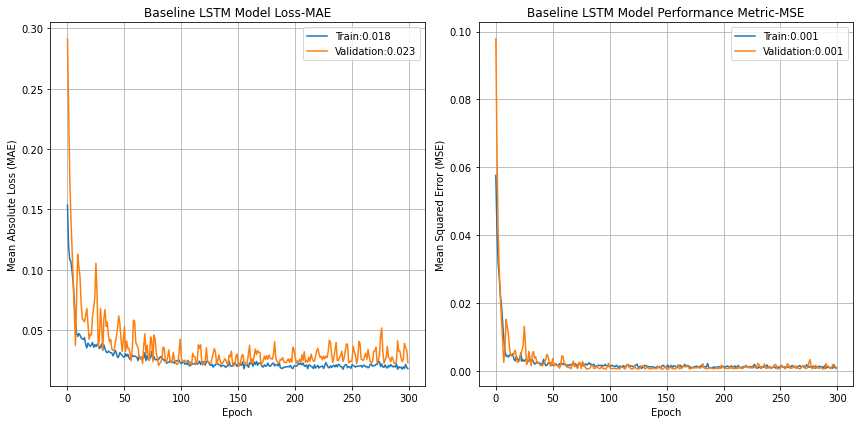

In [28]:
# Plotting model performance
plot_performance(history2, "Baseline LSTM")

### Making predictions on the train data

In [29]:
predicted_values2, groundtruth= make_predictions(model2)
df['forecast_lstm'] = np.zeros(df.shape[0])
predictions = np.zeros(df.shape[0])
predictions[-55:]=predicted_values2
df['forecast_lstm_baseline'] = predictions

Checking performance of the model on actual v/s predicted values

In [30]:
# calculate RMSE
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
rmse = np.sqrt(mean_squared_error(groundtruth, predicted_values2))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(groundtruth, predicted_values2)
print('Test MAE: %.3f' % mae)


Test RMSE: 8.405
Test MAE: 7.184


In [31]:
import sklearn.metrics as sm
print("R^2 score =", round(sm.r2_score(groundtruth, predicted_values2), 2))

R^2 score = 0.72


In [101]:
model2.save("baseline_lstm_model.h5")

Plotting actual v/s predicted values for last 20% of the data selected for testing

<Figure size 864x720 with 0 Axes>

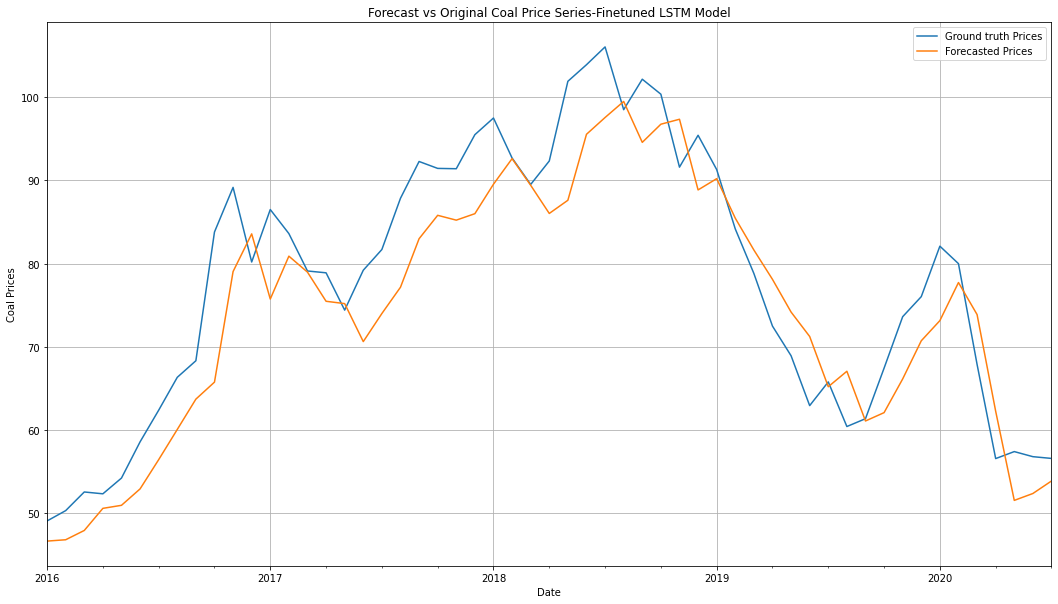

In [102]:
mpl.rcParams['axes.grid'] = True ## Set true for getting grid lines
plt.figure(figsize=(12,10));
df.iloc[-55:][['Coal.SA','forecast_lstm_baseline']].plot();
plt.title("Forecast vs Original Coal Price Series-Finetuned LSTM Model");
plt.ylabel("Coal Prices")
plt.legend(labels=("Ground truth Prices","Forecasted Prices"))

### Visualizations

As we see, the model is not yet good at predicting the values of coal prices form the first assigned hyperparameter values. We will now use hyperparameter search to try and fine-tune our model

In [104]:
# LSTM network design: We use a small 2-layered LSTM model with 1 dropout layer to start with
model2 = Sequential()
# LSTM Block
model2.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True)) 
model2.add(LSTM(64, return_sequences = False)) 
# Dense and Output Layer
model2.add(Dense(16))
model2.add(Dropout(0.15))
model2.add(Dense(5))
model2.add(Dense(1))

opt = optimizers.Adam(learning_rate=0.001)
model2.compile(loss='MAE', optimizer=opt, metrics=["MSE"])

# viewing model summary
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 64)             19200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_3 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 85        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6         
Total params: 53,355
Trainable params: 53,355
Non-trainable params: 0
__________________________________________________

In [105]:
history2 = model2.fit(train_X, train_y, epochs=300, batch_size=64, validation_split=0.2, verbose=2, shuffle=True)

Epoch 1/300
4/4 - 4s - loss: 0.1723 - MSE: 0.0727 - val_loss: 0.3998 - val_MSE: 0.1852
Epoch 2/300
4/4 - 0s - loss: 0.1296 - MSE: 0.0489 - val_loss: 0.3047 - val_MSE: 0.1152
Epoch 3/300
4/4 - 0s - loss: 0.1204 - MSE: 0.0344 - val_loss: 0.2205 - val_MSE: 0.0673
Epoch 4/300
4/4 - 0s - loss: 0.1131 - MSE: 0.0251 - val_loss: 0.1702 - val_MSE: 0.0440
Epoch 5/300
4/4 - 0s - loss: 0.1021 - MSE: 0.0204 - val_loss: 0.1327 - val_MSE: 0.0290
Epoch 6/300
4/4 - 0s - loss: 0.0803 - MSE: 0.0155 - val_loss: 0.0919 - val_MSE: 0.0160
Epoch 7/300
4/4 - 0s - loss: 0.0574 - MSE: 0.0094 - val_loss: 0.0534 - val_MSE: 0.0042
Epoch 8/300
4/4 - 0s - loss: 0.0474 - MSE: 0.0055 - val_loss: 0.1669 - val_MSE: 0.0314
Epoch 9/300
4/4 - 0s - loss: 0.0517 - MSE: 0.0065 - val_loss: 0.1815 - val_MSE: 0.0367
Epoch 10/300
4/4 - 0s - loss: 0.0544 - MSE: 0.0067 - val_loss: 0.0897 - val_MSE: 0.0109
Epoch 11/300
4/4 - 0s - loss: 0.0462 - MSE: 0.0050 - val_loss: 0.0654 - val_MSE: 0.0056
Epoch 12/300
4/4 - 0s - loss: 0.0422 - MS

Epoch 94/300
4/4 - 0s - loss: 0.0241 - MSE: 0.0017 - val_loss: 0.0276 - val_MSE: 0.0011
Epoch 95/300
4/4 - 0s - loss: 0.0251 - MSE: 0.0021 - val_loss: 0.0269 - val_MSE: 0.0010
Epoch 96/300
4/4 - 0s - loss: 0.0252 - MSE: 0.0018 - val_loss: 0.0322 - val_MSE: 0.0016
Epoch 97/300
4/4 - 0s - loss: 0.0240 - MSE: 0.0018 - val_loss: 0.0359 - val_MSE: 0.0019
Epoch 98/300
4/4 - 0s - loss: 0.0243 - MSE: 0.0015 - val_loss: 0.0306 - val_MSE: 0.0015
Epoch 99/300
4/4 - 0s - loss: 0.0248 - MSE: 0.0018 - val_loss: 0.0483 - val_MSE: 0.0031
Epoch 100/300
4/4 - 0s - loss: 0.0238 - MSE: 0.0016 - val_loss: 0.0258 - val_MSE: 0.0010
Epoch 101/300
4/4 - 0s - loss: 0.0246 - MSE: 0.0014 - val_loss: 0.0246 - val_MSE: 9.1228e-04
Epoch 102/300
4/4 - 0s - loss: 0.0276 - MSE: 0.0021 - val_loss: 0.0247 - val_MSE: 9.6522e-04
Epoch 103/300
4/4 - 0s - loss: 0.0245 - MSE: 0.0019 - val_loss: 0.0461 - val_MSE: 0.0030
Epoch 104/300
4/4 - 0s - loss: 0.0235 - MSE: 0.0017 - val_loss: 0.0341 - val_MSE: 0.0018
Epoch 105/300
4/4 -

Epoch 186/300
4/4 - 0s - loss: 0.0213 - MSE: 0.0014 - val_loss: 0.0301 - val_MSE: 0.0014
Epoch 187/300
4/4 - 0s - loss: 0.0223 - MSE: 0.0016 - val_loss: 0.0446 - val_MSE: 0.0028
Epoch 188/300
4/4 - 0s - loss: 0.0218 - MSE: 0.0013 - val_loss: 0.0382 - val_MSE: 0.0022
Epoch 189/300
4/4 - 0s - loss: 0.0213 - MSE: 0.0014 - val_loss: 0.0497 - val_MSE: 0.0034
Epoch 190/300
4/4 - 0s - loss: 0.0241 - MSE: 0.0016 - val_loss: 0.0500 - val_MSE: 0.0034
Epoch 191/300
4/4 - 0s - loss: 0.0190 - MSE: 8.7327e-04 - val_loss: 0.0486 - val_MSE: 0.0032
Epoch 192/300
4/4 - 0s - loss: 0.0232 - MSE: 0.0021 - val_loss: 0.0334 - val_MSE: 0.0017
Epoch 193/300
4/4 - 0s - loss: 0.0219 - MSE: 0.0014 - val_loss: 0.0274 - val_MSE: 0.0012
Epoch 194/300
4/4 - 0s - loss: 0.0235 - MSE: 0.0019 - val_loss: 0.0274 - val_MSE: 0.0011
Epoch 195/300
4/4 - 0s - loss: 0.0208 - MSE: 0.0012 - val_loss: 0.0353 - val_MSE: 0.0019
Epoch 196/300
4/4 - 0s - loss: 0.0218 - MSE: 0.0015 - val_loss: 0.0430 - val_MSE: 0.0027
Epoch 197/300
4/4

Epoch 278/300
4/4 - 0s - loss: 0.0218 - MSE: 0.0013 - val_loss: 0.0289 - val_MSE: 0.0013
Epoch 279/300
4/4 - 0s - loss: 0.0227 - MSE: 0.0014 - val_loss: 0.0286 - val_MSE: 0.0012
Epoch 280/300
4/4 - 0s - loss: 0.0232 - MSE: 0.0018 - val_loss: 0.0274 - val_MSE: 0.0011
Epoch 281/300
4/4 - 0s - loss: 0.0238 - MSE: 0.0019 - val_loss: 0.0585 - val_MSE: 0.0045
Epoch 282/300
4/4 - 0s - loss: 0.0221 - MSE: 0.0015 - val_loss: 0.0412 - val_MSE: 0.0025
Epoch 283/300
4/4 - 0s - loss: 0.0224 - MSE: 0.0015 - val_loss: 0.0295 - val_MSE: 0.0014
Epoch 284/300
4/4 - 0s - loss: 0.0221 - MSE: 0.0013 - val_loss: 0.0295 - val_MSE: 0.0014
Epoch 285/300
4/4 - 0s - loss: 0.0218 - MSE: 0.0014 - val_loss: 0.0459 - val_MSE: 0.0030
Epoch 286/300
4/4 - 0s - loss: 0.0242 - MSE: 0.0015 - val_loss: 0.0365 - val_MSE: 0.0021
Epoch 287/300
4/4 - 0s - loss: 0.0218 - MSE: 0.0016 - val_loss: 0.0281 - val_MSE: 0.0011
Epoch 288/300
4/4 - 0s - loss: 0.0240 - MSE: 0.0018 - val_loss: 0.0299 - val_MSE: 0.0014
Epoch 289/300
4/4 - 0

In [106]:
predicted_values2, groundtruth= make_predictions(model2)
df['forecast_lstm'] = np.zeros(df.shape[0])
predictions = np.zeros(df.shape[0])
predictions[-55:]=predicted_values2
df['forecast_lstm'] = predictions

<Figure size 864x720 with 0 Axes>

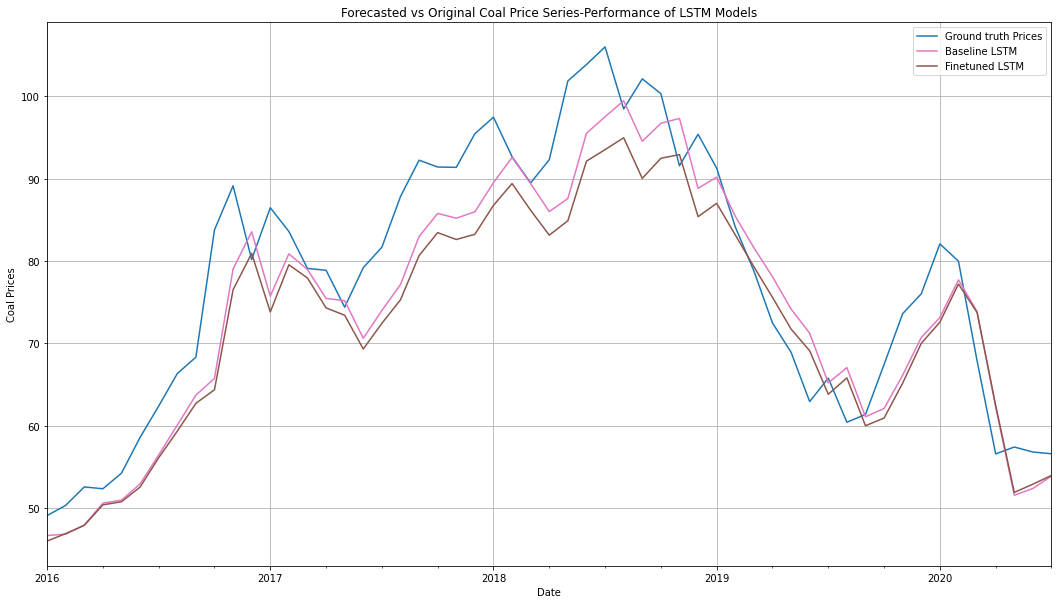

In [107]:
mpl.rcParams['axes.grid'] = True ## Set true for getting grid lines
plt.figure(figsize=(12,10));
df.iloc[-55:][['Coal.SA',"forecast_lstm_baseline", "forecast_lstm"]].plot(color=["#1f77b4",'#e377c2', '#8c564b']);
plt.title("Forecasted vs Original Coal Price Series-Performance of LSTM Models");
plt.ylabel("Coal Prices")
plt.legend(labels=("Ground truth Prices","Baseline LSTM","Finetuned LSTM")) 

# Using Talos for Hyperparameter tuning

In [108]:
# make function to use in talos
def lstm_model(train_X, train_y, val_X, val_y, params ):
    model2 = Sequential()
    # LSTM Block
    model2.add(LSTM(params['layer1_size'], input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True)) 
    model2.add(LSTM(params['layer2_size'], return_sequences = False)) 
    # Dense and Output Layer
    model2.add(Dense(16))
    model2.add(Dropout(params['dropout']))
    model2.add(Dense(5))
    model2.add(Dense(1))
    model.compile(loss='MAE', optimizer=params['optimizer'], metrics=['MSE'])
    # fit network
    out = model.fit(train_X, train_y, epochs=params['epochs'], batch_size=params['batch_size'], validation_split=0.2, verbose=2, shuffle=False)
    # plot history
    return out, model
    

#### Creating params grid for hyperparameters

In [109]:
p = {
     'optimizer': ['AdaDelta', 'adam'],
     'layer1_size': [32, 64, 128, 256],
     'layer2_size': [64,128],
     'batch_size': [32,64, 128],
     'dropout':[0, 0.1,0.15],
     'epochs': [200, 300]}

In [110]:
# Commenting this cell for parameter search, since this runs for a long time. Instead, we are adding the csv file that contains the result of all parameter combinations passed using # the parameter dictionary

# scan_object = talos.Scan(x=train_X,
#                          y=train_y,
#                          params=p,
#                          model=lstm_model, experiment_name = 'LSTM')

In [111]:
# importing csv from LSTM experiment
talos_data = pd.read_csv("LSTM/071921120759.csv")
talos_data.head()

,round_epochs,loss,MSE,val_loss,val_MSE,batch_size,dropout,epochs,layer1_size,layer2_size,optimizer
0,200,0.210894,0.082354,0.134737,0.042894,32,0.0,200,32,16,AdaDelta
1,200,0.015567,0.000681,0.009726,0.000171,32,0.0,200,32,16,adam
2,200,0.219023,0.087390,0.141234,0.045751,32,0.0,200,32,32,AdaDelta
3,200,0.013257,0.000443,0.011233,0.000223,32,0.0,200,32,32,adam
4,200,0.217030,0.088104,0.137565,0.045856,32,0.0,200,32,64,AdaDelta


In [112]:
# # this block is commented since we had already saved the model during the first talos iteration, and we are only loading it from the local machine for testing

# # selecting the best model from all possible models using MAE score from validation data
# best_model = scan_object.best_model(metric='val_mae', asc=True)

# # saving best model and model weights
# best_model.save('timeseries_model.h5')  
# best_model.save_weights('timeseries_weights_lstm.h5')

In [113]:
# loading best model and its weights
from tensorflow.keras.models import load_model
best_model = load_model('timeseries_model.h5')
best_model.load_weights('timeseries_weights_lstm.h5')

# summary of the best model
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 64)             19200     
_________________________________________________________________
activation (Activation)      (None, 1, 64)             0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 52,289
Trainable params: 52,289
Non-trainable params: 0
_________________________________________________________________


### Making predictions with the best model on the original test data

In [114]:
# predictions on test data
yhat_best = best_model.predict(test_X)
test_X_reshape = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat_best, test_X_reshape[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y_reshape = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y_reshape, test_X_reshape[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

### Checking best model performance

In [115]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 6.598


In [116]:
import sklearn.metrics as sm
print("R^2 score =", round(sm.r2_score(inv_y, inv_yhat), 2))

R^2 score = 0.83


## Plotting original v/s predicted data from the best model

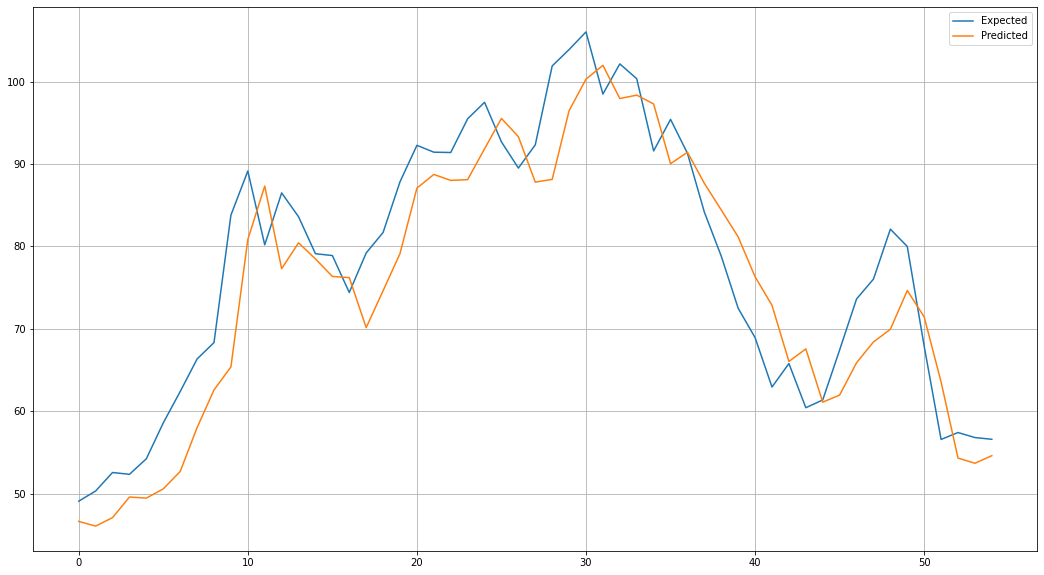

In [117]:
plt.plot(inv_y, label='Expected')
plt.plot(inv_yhat, label='Predicted')
plt.legend()
plt.show()